# Analysis of `floating-car-data.xml`

In [31]:
import pprint, math, datetime
from time import strftime, gmtime
from lxml import etree
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

from paths import normal, scenarios

plt.rcParams["figure.figsize"] = 30, 20
plt.rcParams["font.size"] = 20
plt.rcParams["axes.titlesize"] = 50
plt.rcParams["axes.titlepad"] = 80

### Traffic counts for SUMO edges

In [28]:
def count_vehicles_at_edges(file_path, edges, interval=60*60):
    class SAXParser:
        def __init__(self):
            self.counts = {}
            self.interval_counts = {}

        def start(self, tag, attr):
            if tag == "timestep":
                time = float(attr["time"])
                
                if time > 0 and time % interval == 0:
                    self.counts[time-interval] = self.interval_counts
                    self.interval_counts = {}

            if tag == "vehicle":
                vid = attr["id"]
                edge = attr["lane"].split("_")[0]

                if edge not in edges:
                    return

                if "cluster" in edge:
                    return

                if edge in self.interval_counts:
                    edge_counts = self.interval_counts[edge]
                    if vid not in edge_counts:
                        edge_counts.append(vid)
                        self.interval_counts[edge] = edge_counts
                else:
                    self.interval_counts[edge] = [vid]

        def end(self, tag):
            pass

        def close(self):
            pass

    sax_parser = SAXParser()
    xml_parser = etree.XMLParser(target=sax_parser)
    etree.parse(file_path, parser=xml_parser)

    return sax_parser.counts

matsim_count_edges = ["4067952", "375311156#0", "432205808#0"]

test_count_edges = ["627460044#0"]

interval = 60*60

vehicle_counts_per_edge = count_vehicles_at_edges(f"{normal}/floating-car-data.xml", edges=test_count_edges, interval=interval)

hours = list(map(lambda i: i / interval, vehicle_counts_per_edge.keys()))

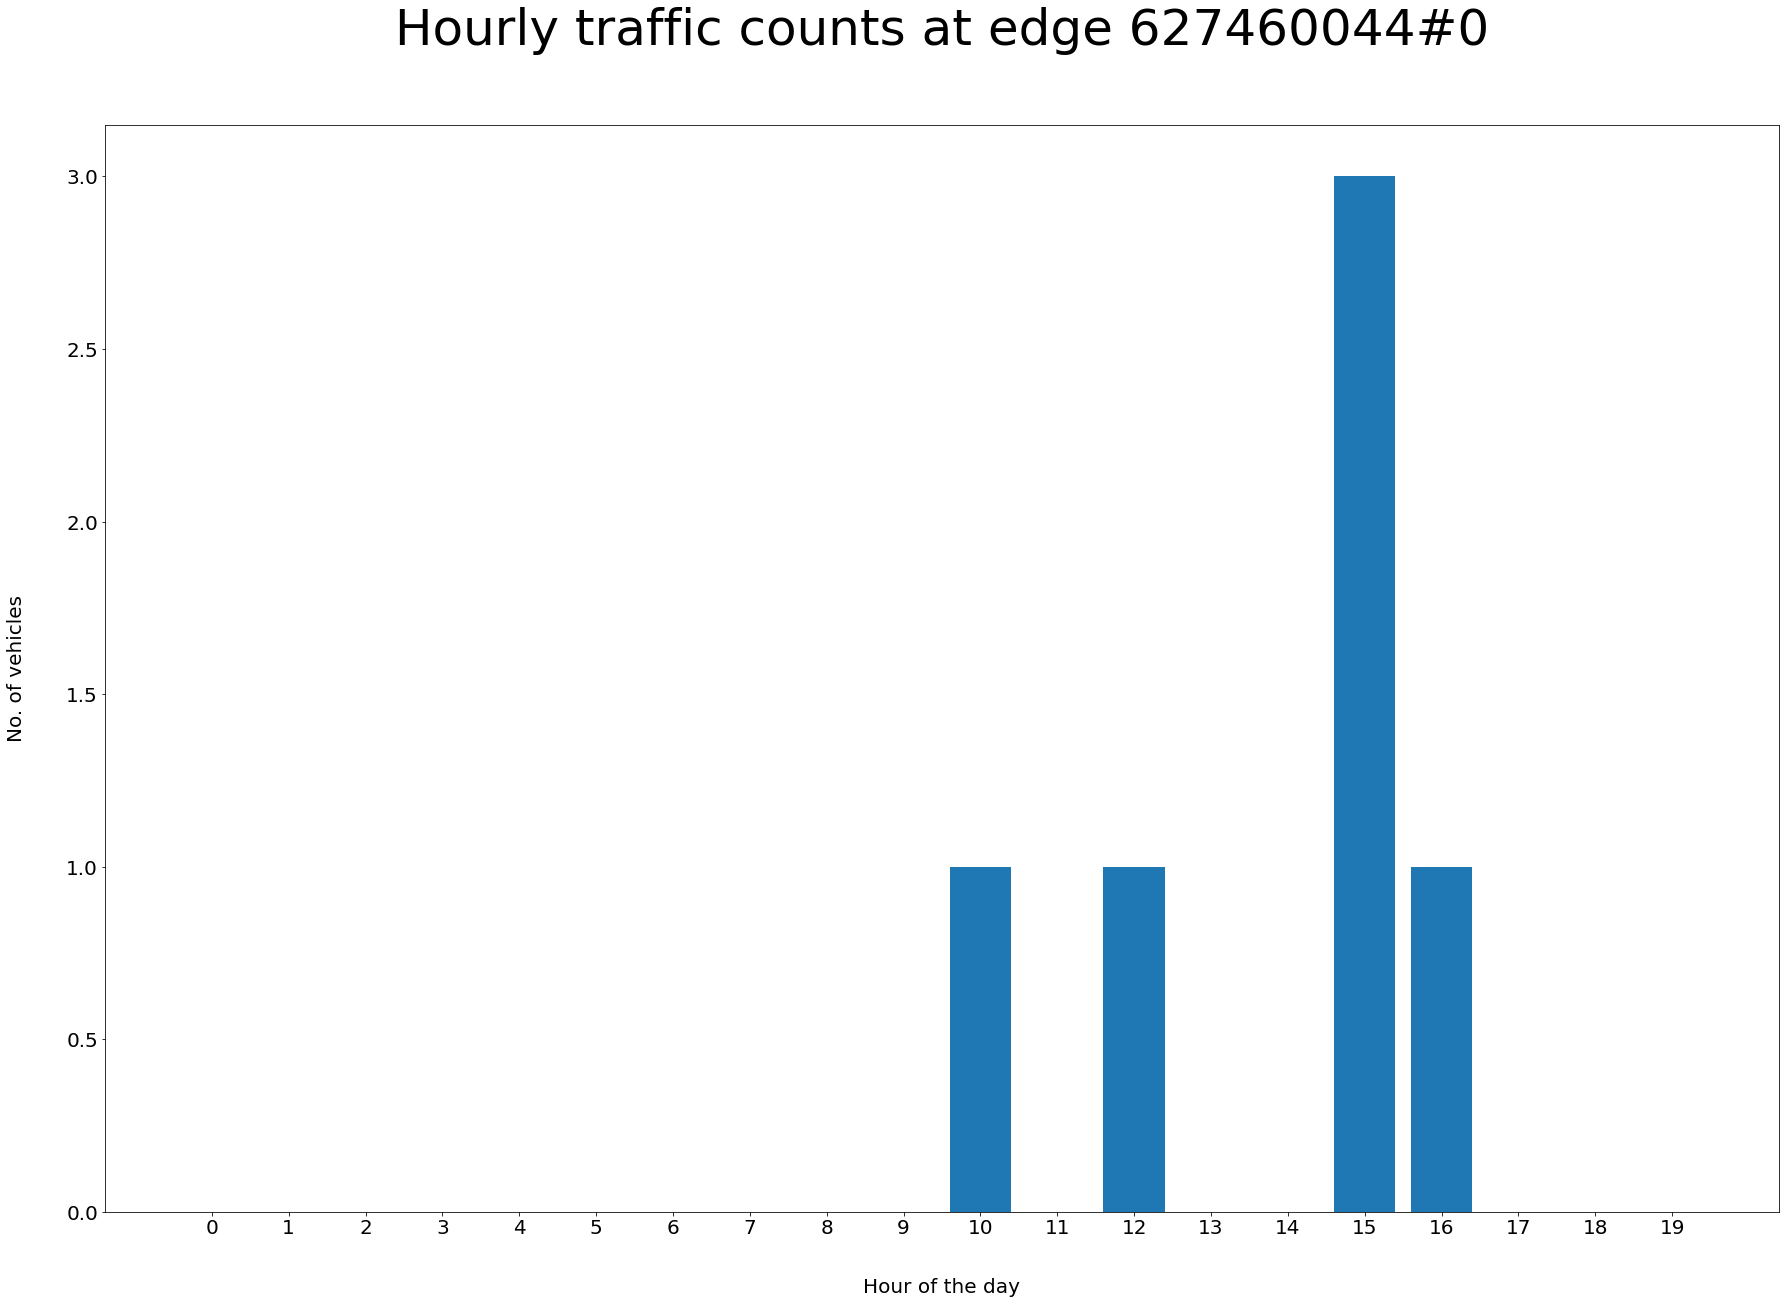

In [30]:
for edge in test_count_edges:
    counts = []
    for edge_counts in vehicle_counts_per_edge.values():
        value = 0
        if edge in edge_counts:
            value = len(edge_counts[edge])

        counts.append(value)

    fig, ax = plt.subplots()
    ax.bar(hours, counts)
    ax.set_xticks(hours)
    ax.set_xlabel("Hour of the day", labelpad=40)
    ax.set_ylabel("No. of vehicles", labelpad=40)
    ax.set_title(f"Hourly traffic counts at edge {edge}")

### Traffic heatmap